<a href="https://colab.research.google.com/github/meKhairul/Algorithms/blob/master/diffusers/latent_diffusion_upscaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image super-resolution using Latent Diffusion

This colab notebook shows how to use the Latent Diffusion image super-resolution model using 🧨 [diffusers](https://github.com/huggingface/diffusers) libray.

The model was originally released in [Latent Diffusion repo](https://github.com/CompVis/latent-diffusion). It's a simple, 4x super-resolution model diffusion model. This model is not conditioned on text.

### Install the Deps

In [26]:
!pip install -qq diffusers==0.11.1 accelerate

### Imports

In [27]:
import torch
from torch import nn
from PIL import Image
import requests
from io import BytesIO

from diffusers import LDMSuperResolutionPipeline

In [28]:
class DDIM_Sampler(nn.Module):
    
    def __init__(self,
                 num_timesteps=100,
                 train_timesteps=1000,
                 clip_sample=True,
                 schedule='linear'
                ):
        
        super().__init__()
        
        self.num_timesteps=num_timesteps
        self.train_timesteps=train_timesteps
        self.ratio=self.train_timesteps // self.num_timesteps
        self.final_alpha_cumprod=torch.tensor([1.0])
        self.clip_sample=clip_sample
        self.schedule=schedule
        
        self.register_buffer('betas',get_beta_schedule(self.schedule,self.train_timesteps))
        self.register_buffer('betas_sqrt',self.betas.sqrt())
        self.register_buffer('alphas',1-self.betas)
        self.register_buffer('alphas_cumprod',torch.cumprod(self.alphas,0))
        self.register_buffer('alphas_cumprod_sqrt',self.alphas_cumprod.sqrt())
        self.register_buffer('alphas_one_minus_cumprod_sqrt',(1-self.alphas_cumprod).sqrt())
        self.register_buffer('alphas_sqrt',self.alphas.sqrt())
        self.register_buffer('alphas_sqrt_recip',1/(self.alphas_sqrt))
        
    @torch.no_grad()
    def forward(self,*args,**kwargs):   
        return self.step(*args,**kwargs)
    
    @torch.no_grad()
    def step(self,x_t,t,z_t,eta=0):
        """
            Given approximation of noise z_t in x_t predict x_(t-1)
        """
        assert (t<self.num_timesteps).all()
        b,c,h,w=z_t.shape
        device=z_t.device
        
        # compute steps based on the ratio (number of DDPM steps to take in each DDIM)
        t=t*self.ratio
        t_prev=t-self.ratio

        # parameters        
        alpha_cumprod_prev = self.alphas_cumprod[t_prev].where(t_prev.ge(0), self.final_alpha_cumprod.to(device)) # >= 0
        alpha_cumprod_prev = alpha_cumprod_prev.view(b,1,1,1)
        alpha_cumprod_prev_sqrt = self.alphas_cumprod_prev_sqrt[t_prev]
        
        # estimate origin
        x_0_pred=self.estimate_origin(x_t,t,z_t)
        if self.clip_sample:
            x_0_pred=torch.clamp(x_0_pred, -1, 1)
            
        std_dev_t = eta * self.estimate_std(t,t_prev).view(b,1,1,1)
        x_0_grad = (1-alpha_cumprod_prev - std_dev_t**2).sqrt() * z_t
        prev_sample=alpha_cumprod_prev_sqrt*x_0_pred + x_0_grad

        if eta > 0:          
            noise = torch.randn(model_output.shape, dtype=model_output.dtype)                    
            prev_sample = prev_sample+std_dev_t*eta*noise

        return prev_sample
    
    def estimate_std(self, t,t_prev):
        alpha_cumprod = self.alphas_cumprod[t]
        alpha_cumprod_prev = self.alphas_cumprod[t_prev].where(t_prev.gt(0), self.final_alpha_cumprod.to(alpha_cumprod.device))
        one_minus_alpha_cumprod = 1 - alpha_cumprod
        one_minus_alpha_cumprod_prev = 1 - alpha_cumprod_prev

        var = (one_minus_alpha_cumprod_prev / one_minus_alpha_cumprod) * (1 - alpha_cumprod / alpha_cumprod_prev)

        return var.sqrt()
    
    def estimate_origin(self,x_t,t,z_t):
        alpha_cumprod = self.alphas_cumprod[t].view(b,1,1,1)
        alpha_one_minus_cumprod_sqrt=alphas_one_minus_cumprod_sqrt[t]
        return(x_t-alpha_one_minus_cumprod_sqrt*z_t)/alpha_cumprod.sqrt()

### Load the pipeline

In [29]:
device = "cuda"
pipe = LDMSuperResolutionPipeline.from_pretrained( "CompVis/ldm-super-resolution-4x-openimages")
pipe = pipe.to(device)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

### Get the image for demo

In [30]:
def lowVhigh(l,h):
  images = [l,h]
  widths, heights = zip(*(i.size for i in images))

  total_width = sum(widths)
  max_height = max(heights)

  new_im = Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

  new_im.show()

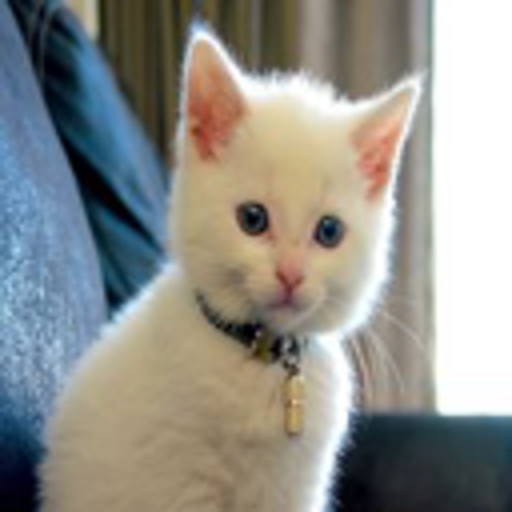

In [37]:
# let's download an  image
url = "https://i.pinimg.com/236x/af/84/56/af8456faa55d76bd9afa18cd2fd72d58.jpg"
response = requests.get(url)
low_res_img = Image.open(BytesIO(response.content)).convert("RGB")
low_res_img = low_res_img.resize((128, 128))
ls = low_res_img.resize((512,512))
ls.show()

### Run pipeline to upscale the image

In [38]:
# run pipeline in inference (sample random noise and denoise)
upscaled_image = pipe(low_res_img, num_inference_steps=100, eta=1).images[0]

  0%|          | 0/100 [00:00<?, ?it/s]

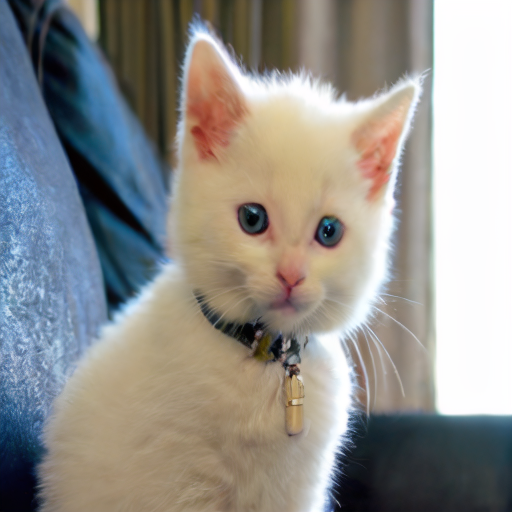

In [39]:
upscaled_image

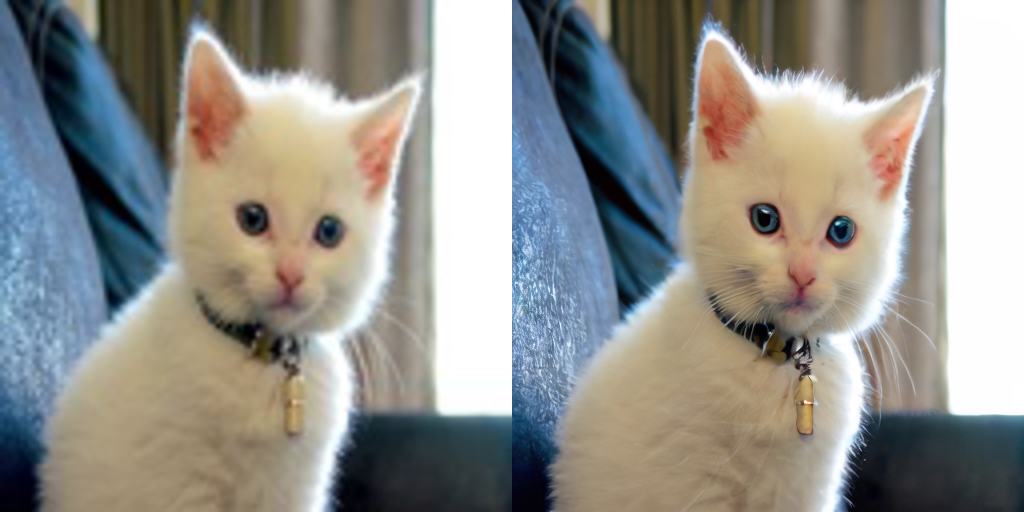

In [33]:
lowVhigh(ls,upscaled_image)

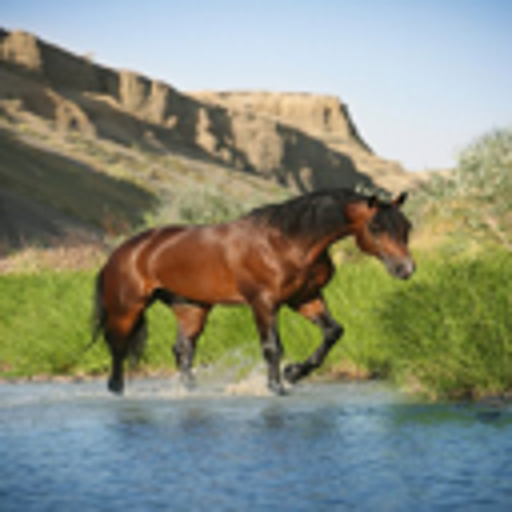

In [34]:
# let's download an  image
url = "https://i.pinimg.com/originals/ab/ec/e2/abece20d55b78afb325d98322a61fa6b.jpg"
response = requests.get(url)
low_res_img = Image.open(BytesIO(response.content)).convert("RGB")
low_res_img = low_res_img.resize((128, 128))
ls = low_res_img.resize((512,512))
ls.show()

  0%|          | 0/100 [00:00<?, ?it/s]

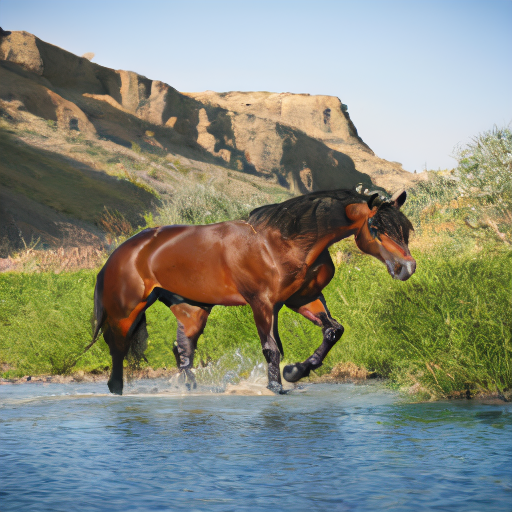

In [35]:
upscaled_image = pipe(low_res_img, num_inference_steps=100, eta=1).images[0]
upscaled_image

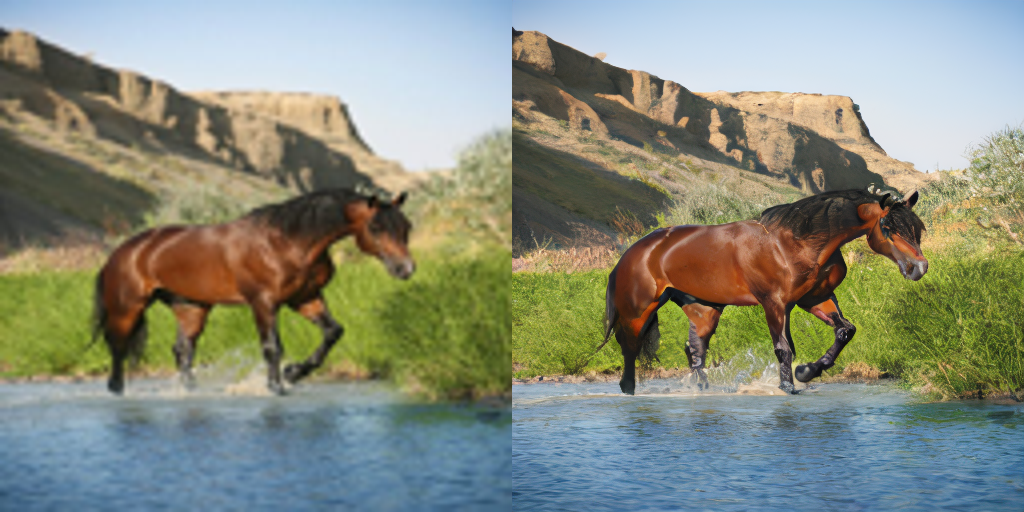

In [36]:
lowVhigh(ls,upscaled_image)